In [1]:
import baostock as bs
import pandas as pd
import numpy as np

# 计算日度回报率
def calculate_daily_returns(df):
    df['close'] = df['close'].astype(float)
    df['daily_return'] = df['close'].pct_change()  # 计算日度回报率
    return df

# 获取股票历史数据
def fetch_stock_data(stock_code, start_date, end_date, fields, file_name):
    # 登录
    lg = bs.login()
    if lg.error_code != '0':
        print(f"登录失败，错误代码：{lg.error_code}，错误信息：{lg.error_msg}")
        return None
    
    # 获取历史数据
    rs = bs.query_history_k_data_plus(stock_code,  # 股票代码
                                      fields,  # 需要的字段
                                      start_date=start_date,  # 起始日期
                                      end_date=end_date,  # 结束日期
                                      frequency="d",  # 数据频率：'d'表示日线
                                      adjustflag='3')  # 复权：'3'表示前复权
    
    # 获取数据
    data = []
    while rs.next():
        data.append(rs.get_row_data())
    
    if data:
        df = pd.DataFrame(data, columns=fields.split(','))
        df = calculate_daily_returns(df)
        df.to_csv(file_name, index=False)
        print(f"股票数据已保存到 {file_name}")
    else:
        print("没有获取到数据")
    
    bs.logout()

# 获取市场指数数据（例如：上证指数）
def fetch_market_data(market_code, start_date, end_date, fields, file_name):
    lg = bs.login()
    if lg.error_code != '0':
        print(f"登录失败，错误代码：{lg.error_code}，错误信息：{lg.error_msg}")
        return None
    
    # 获取市场指数数据
    rs = bs.query_history_k_data_plus(market_code,  # 市场指数代码
                                      fields,  # 需要的字段
                                      start_date=start_date,  # 起始日期
                                      end_date=end_date,  # 结束日期
                                      frequency="d",  # 数据频率：'d'表示日线
                                      adjustflag='3')  # 复权：'3'表示前复权
    
    # 获取数据
    data = []
    while rs.next():
        data.append(rs.get_row_data())
    
    if data:
        df = pd.DataFrame(data, columns=fields.split(','))
        df = calculate_daily_returns(df)
        df.to_csv(file_name, index=False)
        print(f"市场数据已保存到 {file_name}")
    else:
        print("没有获取到市场数据")
    
    bs.logout()


# 数据集准备

## 函数库

In [ ]:
import plotly.express as px
start='2023-12-01'
end='2024-11-30'
def Interplolate(df,time,order=2):
    df.loc[:,time]=pd.to_datetime(df[time])
    df.set_index(time,inplace=True)
    date_range = pd.date_range(start=start, end=end, freq='D')
    df = df[start:end].reindex(date_range)
    if np.isnan(df.iloc[0].item()):
        df.iloc[0]=df.mean().item()
    return df,df.interpolate(method='spline',order=order)

def BfAfInterplolate(df,df_filled):
    fig = px.line(x=df.index, y=df[df.columns[0]], line_shape='linear', title="Yield over Time")

    fig.add_scatter(x=df_filled.index, y=df_filled[df_filled.columns[0]], mode='lines', name="Interpolated Data", line=dict(color='red'))
    var=np.var(df_filled.to_numpy())
    mean=np.mean(df_filled.to_numpy())
    fig.update_traces(connectgaps=False)
    fig.update_layout(
        title="Yield over Time",
        xaxis_title="Date",
        yaxis_title="Yield(%)",
        legend_title="Data",
        legend=dict(
            title="Legend",
            x=1,
            y=1
        )
    )
   
    fig.add_annotation(
        x=df_filled.index[len(df_filled)//2],  # 放置注释的x位置
        y=max(df_filled[df_filled.columns[0]]),  # 放置注释的y位置
        text=f"Variance: {var:.4f}Mean: {mean:.4f}",  # 方差值，保留四位小数
        showarrow=False,  # 不显示箭头
        font=dict(size=12, color='black'),  # 设置字体大小和颜色
        bgcolor='white'  # 背景颜色
    )
 
    fig.show()

def CalYield(Clsprc):
    e=Clsprc.to_numpy()
    e_filled = np.zeros(e.shape[0] + 1) 
    e_filled[1:]=e
    e_filled[0]=2*e[0]-e[1]
    Yield=np.log(e_filled[1:]/e_filled[:-1])*100
    return Yield
    
def StkProcessing(df,code,columns):
    df_dict={}
    for column in columns:
        col_df = df[df[code].notnull()][[code, column]].pivot(columns=code, values=column)
        df_dict[column] = col_df[start:end]
    
    return df_dict


## 数据清洗

In [ ]:
import pandas as pd
import numpy as np
Market=pd.read_csv('TRD_Cndalym.csv')
Amarket=Market[Market['Markettype']==5]
Amarket.loc[:,'Cdretmdos'] = Amarket['Cdretmdos'] * 100
marketflow=Amarket[['Trddt','Cdretmdos']]

lowrisk=pd.read_csv('BND_TreasYield.csv')
lowrisk=lowrisk[lowrisk['Cvtype']==2]
lowrisk_1y=lowrisk[lowrisk['Yeartomatu']==1][['Trddt','Yield']]
lowrisk_1y.loc[:,'Yield']=lowrisk_1y['Yield'].astype(np.float64)/365
lowrisk_1y,lowrisk_1y_filled=Interplolate(lowrisk_1y,'trddt')

marketflow,marketflow_filled=Interplolate(marketflow,'trddt',1)
filled_datalist=[marketflow_filled,lowrisk_1y_filled]
datalist=[marketflow,lowrisk_1y]



In [48]:
time='TradingDate'
code='Symbol'
stks1=pd.read_csv('TRD_FwardQuotation4.csv').set_index(time)
stks2=pd.read_csv('TRD_FwardQuotation5.csv').set_index(time)
combined_df = pd.concat([stks1, stks2])
columns=['OpenPrice','ClosePrice','TurnoverRate1','MarketValue','CirculatedMarketValue']
stkdf_dict=StkProcessing(combined_df,code,columns)


OpenPrice Symbol       603121  603122  603123  603125  603126  603127  603128  603129  \
TradingDate                                                                   
2023-12-01    9.055   8.512   11.61  20.539   6.899  26.343   7.299  93.656   
2023-12-04    9.084   8.502   11.76  20.532   6.938  26.116   7.614  90.432   
2023-12-05    9.182   8.403   11.67  20.471   6.958  24.307   7.744  87.612   
2023-12-06    9.770   8.364   11.32  20.163   6.850  23.230   7.549  88.637   
2023-12-07    9.447   8.423   11.21  20.067   6.889  23.912   7.354  86.961   

Symbol       603130  603131  ...  920016  920019  920060  920066  920088  \
TradingDate                  ...                                           
2023-12-01   21.336   15.84  ...     NaN     NaN     NaN     NaN     NaN   
2023-12-04   21.816   16.02  ...     NaN     NaN     NaN     NaN     NaN   
2023-12-05   21.718   15.44  ...     NaN     NaN     NaN     NaN     NaN   
2023-12-06   21.434   14.96  ...     NaN     NaN     NaN

## 数据集划分

In [4]:
#spilt
def split(datalist, a=0.8):
    train_datas = []
    test_datas = []
    
    for df in datalist:
        # 获取数据的分割点
        train_size = int(len(df) * a)  # 计算训练集的大小
        
        # 切割数据集
        train_data = df.iloc[:train_size]  # 前 a% 的数据作为训练集
        test_data = df.iloc[train_size:]  # 剩余的数据作为测试集
        
        # 添加到对应的列表
        train_datas.append(train_data)
        test_datas.append(test_data)
    
    return train_datas, test_datas
train_datas,test_datas=split(filled_datalist)
org_train,org_test=split(datalist)


## 收益率曲线展示

In [4]:
for df,filled_df,test_df,filled_test_df in zip(org_train,train_datas,org_test,test_datas):
    BfAfInterplolate(df,filled_df)
    BfAfInterplolate(test_df,filled_test_df)

# 收益率溢价评估

## 协方差矩阵与期望估计 蒙特卡洛方法

In [ ]:
def MonteCarlo(data):
    


## CAPM

In [ ]:
stk_index=np.arange(len(train_datas))[2:]
def CalBetas(datalist,market_index,stk_index):
    betas=[]
    for i in stk_index:
        cov=np.cov(datalist[i].to_numpy().flatten(),datalist[market_index].to_numpy().flatten())
        betai=cov[0,1]/cov[1,1]
        betas.append(betai)
    return betas

def CalERi(datalist,betas,market_index,lowrisk_index,episilon):
    m=np.array(datalist)[market_index].squeeze(1)
    l=np.array(datalist)[lowrisk_index].squeeze(1)
    delta=m-l
    return np.array(betas).reshape(-1,1)@delta.reshape(1,-1)+l

def GetCovMatrix(datalist,stk_index):
    return np.cov(np.array(datalist)[stk_index].squeeze(2),rowvar=True)

betas=CalBetas(train_datas,0,stk_index)
ERi=CalERi(train_datas,betas,0,1)
CovMatrix=GetCovMatrix(train_datas,stk_index)



## 资产组合优化

## numpy解析法

In [ ]:
def minimize_sigma(sigma,u,u_star):
    '''np方法得到给定收益率期望下使得风险系数最小的权重向量解析解'''
    one=np.zeros((u.shape[0],1))+1
    inv_sigma=np.linalg.inv(sigma)
    A=np.concatenate((one.T,u.T))
    P1=one.T@inv_sigma@A.T
    P2=u.T@inv_sigma@A.T
    P=np.concatenate((P1,P2))
    b=np.matrix([1,u_star]).reshape(2,1)
    lambdas=np.linalg.solve(P,b)
    return lambdas.T@A@inv_sigma

u=ERi[:,100].reshape(ERi.shape[0],1)
w=minimize_sigma(CovMatrix,u,1)

U=w@u
var=w@CovMatrix@w.T

print(w)
print(U/np.sqrt(var))

[[-13.99655427   4.41491741   4.77750245   4.37616371   1.48935831
   -0.06138761]]
[[0.03729121]]


## cvxpy凸优化库二次规划

In [65]:
import cvxpy as cp
def cp_minimize_sigma(CovMatrix,u,ustar):
    w=cp.Variable(u.shape[0])

    objective=cp.Minimize(cp.quad_form(w,CovMatrix))

    constrains=[cp.sum(w)==1,w>=0,w@u>=ustar]

    problem=cp.Problem(objective,constrains)
    problem.solve()
    if problem.status not in ["infeasible", "unbounded"]:
        return w.value,cp.quad_form(w,CovMatrix).value
    else:
        raise ValueError("minimize Optimization did not succeed. Status: " + problem.status)
def cp_maximize_u(CovMatrix,u,sig):
    w=cp.Variable(u.shape[0])

    objective=cp.Maximize(w@u)

    constrains=[cp.sum(w)==1,w>=0,cp.quad_form(w,CovMatrix)<=sig]

    problem=cp.Problem(objective,constrains)
    problem.solve()
    if problem.status not in ["infeasible", "unbounded"]:
        return w.value,cp.quad_form(w,CovMatrix).value
    else:
        raise ValueError("maximize Optimization did not succeed. Status: " + problem.status)
ustar=0.08
sig=1.2
w1,s1=cp_maximize_u(CovMatrix,u,sig)
w2,s2=cp_minimize_sigma(CovMatrix,u,ustar)

print(w1@u/np.sqrt(s1),w1@u,s1)
print(w2@u/np.sqrt(s2),w2@u,s2)


[0.0774464] [0.08483828] 1.1999999986675858
[0.07553303] [0.08] 1.1217761666755681


[[1.  ]
 [0.05]]
[[  2.07434474]
 [-14.74472998]]


matrix([[ 0.88492464, -0.10171961, -0.13626085,  0.18336403,  0.12632587,
          0.04336592]])

# 回测

## 策略集

In [73]:
def buy_strategy(daycount,df):
    buy_signals = {}
    if daycount//30==0:
        for stock, price in df.iloc[daycount].items():
            if price <df[stock].iloc[:daycount].mean()-df[stock].iloc[:daycount].std() : 
                buy_signals[stock] = 10  # 买入10股
    return buy_signals


def sell_strategy(daycount,df):
    buy_signals = {}
    if daycount//30==0:
        for stock, price in df.iloc[daycount].items():
            if price >df[stock].iloc[:daycount].mean()+df[stock].iloc[:daycount].std() :
                buy_signals[stock] = 10  # 买入10股
    return buy_signals

## 回测类

In [78]:
import seaborn as sns
class Backtest:
    def __init__(self, stock_data, initial_cash=100000):
        # 初始化股票数据和初始现金
        self.stock_data = stock_data
        self.initial_cash = initial_cash
        self.cash = initial_cash
        self.positions = pd.Series(0, index=stock_data.columns)  # 每只股票持仓
        self.history = []  # 记录每个时间步的账户状态

    def run(self, buy_strategy, sell_strategy):
        day=0
        for self.date, row in self.stock_data.iterrows():
            self._buy(buy_strategy(day,self.stock_data[:self.date]))
            self._sell(sell_strategy(day,self.stock_data[:self.date]))
            self.history.append({
                'date': self.date,
                'cash': self.cash,
                'positions': self.positions.copy(),
                'portfolio_value': self.cash + (self.positions * row).sum()
            })
            day+=1
    
    def _buy(self, buy_signals):
        # 执行买入操作
        for stock, qty in buy_signals.items():
            if qty > 0:
                price = self.stock_data.loc[self.date,stock]  # 当前股票价格
                total_cost = price * qty
                if self.cash >= total_cost:
                    self.cash -= total_cost
                    self.positions[stock] += qty

    def _sell(self, sell_signals):
        # 执行卖出操作
        for stock, qty in sell_signals.items():
            if qty > 0 and self.positions[stock] >= qty:
                price = self.stock_data.loc[self.date,stock]  # 当前股票价格
                self.cash += price * qty
                self.positions[stock] -= qty

    def get_results(self):
        sns.lineplot(pd.DataFrame(self.history)['portfolio_value'])



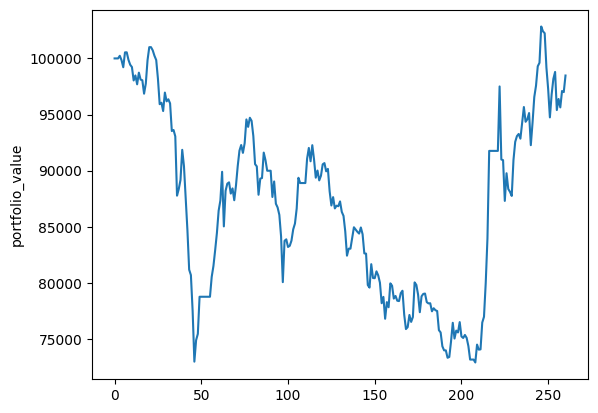

In [79]:
backtest = Backtest(stkdf_dict[columns[1]])

backtest.run(buy_strategy, sell_strategy)

backtest.get_results()



In [69]:
print(stkdf_dict[columns[0]][603121].std())#.std())

1.0666048241770962
